<a href="https://colab.research.google.com/github/rkrissada/100DayOfMLCode/blob/master/day_067_superstore_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superstore Forecasting

We will demonstrate different approaches for forecasting retail sales time series.

In [0]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [0]:
%matplotlib inline
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [0]:
import pandas as pd
df = pd.read_excel("Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [0]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for office supplies.

In [0]:
office = df.loc[df['Category'] == 'Office Supplies']

In [0]:
office['Order Date'].min(), office['Order Date'].max()

(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have 4-year sales data.

## Data Preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [0]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
office.drop(cols, axis=1, inplace=True)

In [0]:
office = office.sort_values('Order Date')
office.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [0]:
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [0]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


### Indexing with time series data

In [0]:
office = office.set_index('Order Date')
office.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [0]:
y = office['Sales'].resample('MS').mean()

### Visualizing Furniture Sales Time Series Data

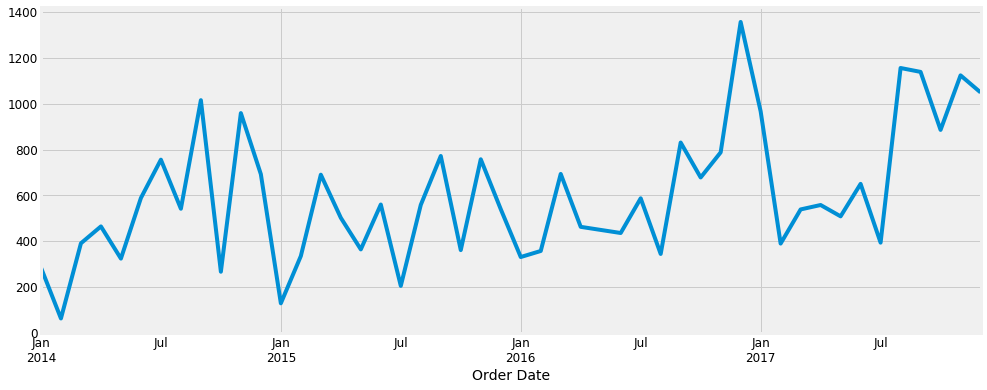

In [0]:
y.plot(figsize=(15,6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern,

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality and noise.

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

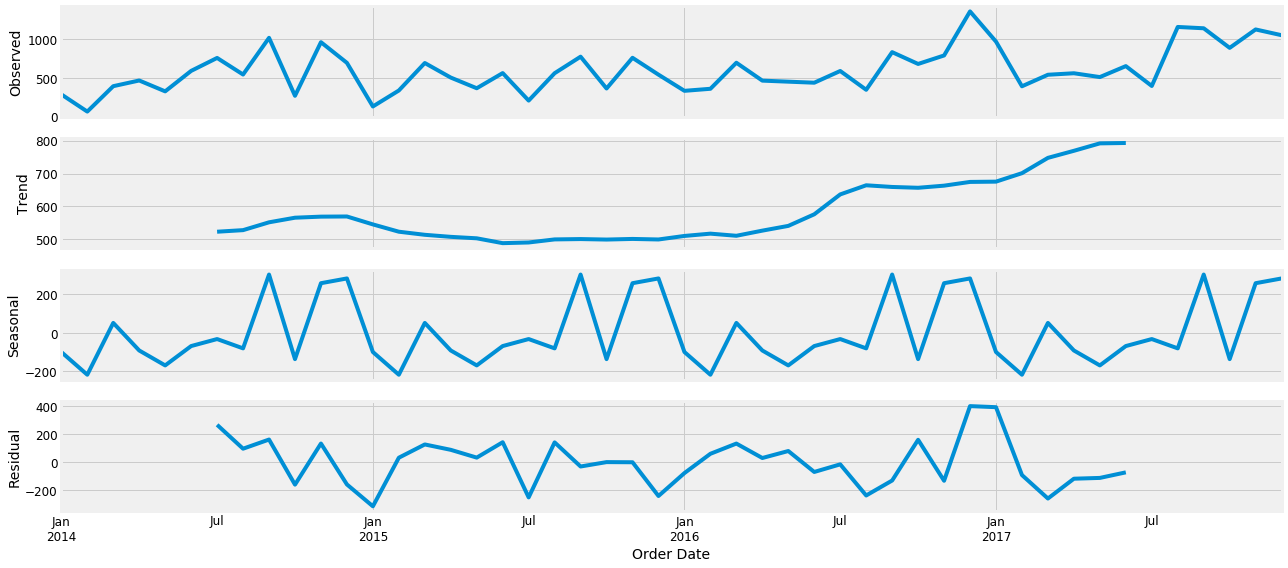

In [0]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of office supplies is unstables, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forcasting, known as ARIMA, which stands for Autoregressive Integrated Moving Averge.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [0]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [0]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our office upplies's sales ARIMA Time Series Model. Our goal here is to use a "grid search" to find the optimal set of parameters that yields the best performance for our model.

In [0]:
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y, order = param, 
                                      seasonal_order = param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False
                                     )
      results = mod.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:747.1990404227043
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1671.9711836031593
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:500.7335398750499
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:516.0876543936834


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1470.1088155654381
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.44488563489716
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:702.6891395292457
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:487.7601415814778
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:517.4952646585912
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2864.5481857511613
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.6922094460116
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:666.4572045007284


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1316.9112044722046
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:503.0840747609876
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:500.0109385290892


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1189.716460715105
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:335.7148959418817
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:637.3530008828179
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2682.502621098955
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:473.7153967455386
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:489.9419970027697
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2893.4629577661635
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:330.70615130932293
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:680.4032716562347
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:801.3444300334154
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:501.7031226672368
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:500.21905344214457


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1029.0843070792112
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:331.07199732555904
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:651.1768264308416


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2720.375468376048
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:488.4314196132827
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:489.2546400441698


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2549.539441526422
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:331.7136802273556
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:658.0713305703066


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1245.9134839623284
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:494.907679737394
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:482.80837530249556
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:321.232546988447
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:638.7962401173484
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2480.3633197058202
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:475.71388519565363
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:478.698730174325
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2688.6257188489476
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:318.2066479084385


The above output suggests that SARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 318.206. Therefore we should consider this to be optimal option.

### Fitting the ARIMA model

In [0]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order = (1, 1, 1),
                                seasonal_order = (1, 1, 0, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False
                               )

results = mod.fit()

In [0]:
print(results.summary().tables[0])
print(results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -155.103
Date:                            Wed, 24 Apr 2019   AIC                            318.207
Time:                                    05:22:00   BIC                            322.571
Sample:                                01-01-2014   HQIC                           319.235
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      0.328      0.755      0.450      -0.395       0.891
ma.L1         -0.9389      0.462   

We should always run model diagnostics to investigate any unusual behavior.

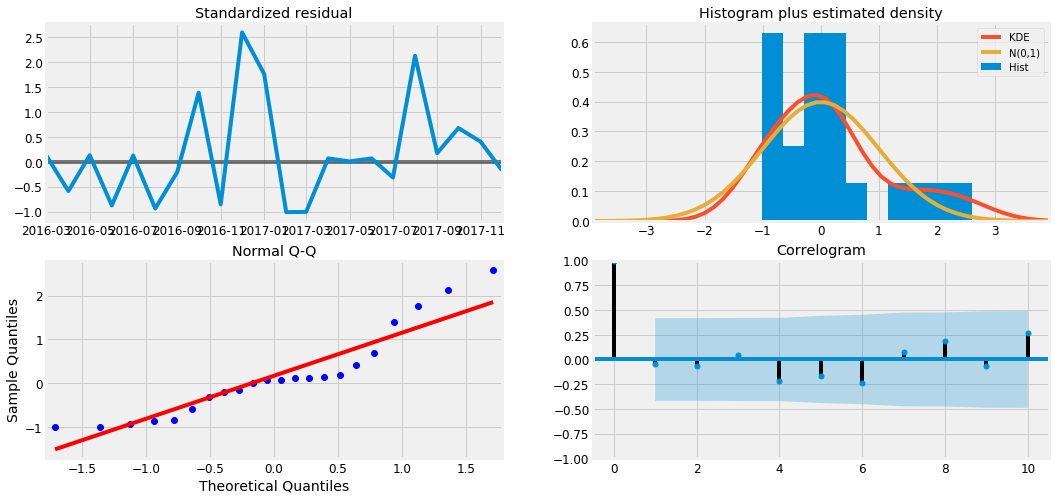

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()